In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [2]:
from lsst.daf.persistence import Butler
from importlib import reload

In [3]:
import lsst.afw.geom as afwGeom
import lsst.afw.cameraGeom
import lsst.geom as geom
from lsst.afw.geom import makeSkyWcs
from lsst.obs.lsst.imsim import ImsimMapper

In [4]:
from collections import OrderedDict as Odict

In [5]:
#import dm_utilities as dmu

In [6]:
calexprepo = '/global/cscratch1/sd/desc/DC2/data/Run2.1i/rerun/calexp-v1' 
b = Butler(calexprepo)
skymap = b.get('deepCoadd_skyMap')

In [7]:
template_repo = '/global/cscratch1/sd/bos0109/templates_rect'
diarepo = template_repo + '/rerun/diff_rect'
assocrepo = diarepo + '/rerun/assoc_sha'
forcerepo = assocrepo + '/rerun/forcedPhot' 
tmprepo = template_repo + '/rerun/multiband'

In [8]:
diabutler = Butler(forcerepo)

In [13]:
cd /global/homes/b/bos0109/run2_diaproc/notebooks

/global/u2/b/bos0109/run2_diaproc/notebooks


In [18]:
truth_lightc = pd.read_csv('../lightcurves/lightcurves_cat_rect_58.0_56.0_-31.0_-32.0.csv')

In [19]:
#sntab = pd.read_csv('./catalogs+tables/supernovae_cat_rect_58_56_-31_-32.csv')
sntab = pd.read_csv('../results/sntab_matched.csv')
snlcs = pd.read_csv('../lightcurves/sn_matched_lcs.csv')
visitab = pd.read_csv('../catalogs+tables/full_t_visits_from_minion.csv')

In [20]:
truth_lightc = truth_lightc[truth_lightc['filter']!='u']
truth_lightc = truth_lightc[truth_lightc['filter']!='y']
visitab = visitab[visitab['filter']!='u']
visitab = visitab[visitab['filter']!='y']
snlcs = snlcs[snlcs['filter']!='u']
snlcs = snlcs[snlcs['filter']!='y']

In [21]:
diaSrc_store = pd.HDFStore('/global/cscratch1/sd/bos0109/diaSrc_fulltables_v3.h5')
diaSrc_store.open()
diaSrcs_tab = diaSrc_store['matched_tab']
basepaths = '/global/cscratch1/sd/bos0109/run2_stamps_v3'

In [22]:
mapper = ImsimMapper()
camera = mapper.camera
trans = [detector.getTransform(lsst.afw.cameraGeom.cameraSys.PIXELS,
         lsst.afw.cameraGeom.cameraSys.FIELD_ANGLE) for detector in camera]
boxes = [detector.getBBox() for detector in camera]
names = [detector.getName() for detector in camera]
det_n = [detector.getId()   for detector in camera]

In [23]:
#region  -----------------------------------------------------------------------
stamp_path = os.path.abspath('/global/cscratch1/sd/bos0109/run2_stamps_v4/')
skymap = diabutler.get("deepCoadd_skyMap")


(array([1.661e+03, 1.630e+02, 1.170e+02, 6.500e+01, 5.700e+01, 2.500e+01,
        1.800e+01, 1.600e+01, 1.500e+01, 1.000e+00]),
 array([ 0. ,  4.7,  9.4, 14.1, 18.8, 23.5, 28.2, 32.9, 37.6, 42.3, 47. ]),
 <a list of 10 Patch objects>)

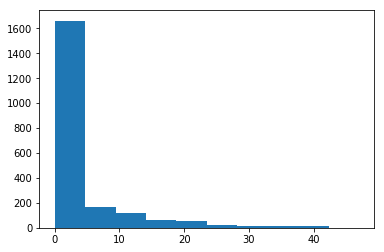

In [49]:
plt.hist(sntab.N_trueobserv)

In [57]:
asn = sntab[sntab.N_trueobserv>20].iloc[0]

In [58]:
asn.snid_in

'MS_9172_56'

In [59]:
ra, dec = asn.snra_in, asn.sndec_in
sn_skyp = afwGeom.SpherePoint(ra, dec, afwGeom.degrees)

In [60]:
lc = snlcs[snlcs.SN_id==asn.snid_in]
lc = lc[lc.observed]
lc = lc[lc['filter']!='y']
lc = lc[lc['filter']!='u']

In [65]:
lc = lc[lc.observable]

In [ ]:
#sndir = os.path.join(stamp_path, f'SN_stamps/{asn.snid_in}')
#if not os.path.exists(sndir):
#    os.makedirs(sndir)
#head = f'id={asn.snid_in}_z={asn.z_in}_mB={asn.mB}'
#head += f'_x0={asn.x0_in}_x1={asn.x1_in}_c={asn.c_in}.snhead'
#open(os.path.join(sndir, head), 'w')

#coadd_id = dmu.get_coadd_id_for_ra_dec(skymap, ra, dec)

In [122]:
visit_box = Odict()

In [123]:
for afilter, flcurve in lc.groupby('filter'):
    #fpath = os.path.join(sndir, afilter)
    #if not os.path.exists(fpath):
    #    os.makedirs(fpath)
    #coadd_id['filter'] = afilter
    stamp_title = f"Coadd SN id={asn.snid_in} filter={afilter} " 

    #coaddstamp_p = os.path.join(fpath, f'stamp_{asn.snid_in}_coadd')
    #coadd_cutout = dmu.make_display_cutout_image(diabutler, coadd_id, 
    #    float(ra), float(dec), dataset_type='deepCoadd', title=stamp_title,
    #    savefits=coaddstamp_p+'.fits', saveplot=coaddstamp_p+'.png')

    for anepoch in flcurve.itertuples():
        dataId = dict(visit=anepoch.visitn)
        datarefs = list(b.subset('calexp', dataId=dataId))
        isin_some_detector=False
        # this circles through detectors
        for i, dataref in enumerate(datarefs):
            calexp = dataref.get('calexp')
            ccd_box = afwGeom.Box2D(calexp.getBBox())
            wcs = calexp.getWcs()
            if ccd_box.contains(wcs.skyToPixel(sn_skyp)):
                print('sn is in dataref: ', dataref.dataId)
                isin_some_detector=True
                diff_id = dataref.dataId
                break
            #center = wcs.pixelToSky(ccd_box.getCenter()).getPosition(afwGeom.degrees)
        if not isin_some_detector:
            print('no detector overlapping sn cats!') 
            continue
        #region  ----------------------------just to find detector number---
        if anepoch.visitn not in visit_box.keys():
            visitf = visitab[visitab.obsHistID==anepoch.visitn]
            if len(visitf)==0: 
                print('visit not in table')
                continue
            bsight = geom.SpherePoint(visitf.descDitheredRA.values[0]*geom.degrees, 
                                      visitf.descDitheredDec.values[0]*geom.degrees)
            orient = (90-visitf.descDitheredRotTelPos.values[0])*geom.degrees
            print(orient)
            orient = (90-visitf.descDitheredRotSkyPos.values[0])*geom.degrees
            print(orient)
            wcs_list = [makeSkyWcs(t, orient, flipX=False, boresight=bsight,
                                    projection='TAN') for t in trans]
            visit_box[anepoch.visitn] = [bsight, orient, wcs_list]
        else:
            bsight, orient, wcs_list = visit_box[anepoch.visitn]

        det_c = [(det, detn) for det, detn, box, wcs in zip(det_n, names, boxes, wcs_list) if \
                    box.contains(afwGeom.Point2I(wcs.skyToPixel(sn_skyp)))]
        #[(det_n[i], detn[i]) for i in range(len(det_n)) if boxes[i].contains(afwGeom.Point2I(wcs_list[i].skyToPixel(sn_skyp)))]
        #[boxes[i].contains(afwGeom.Point2I(wcs_list[i].skyToPixel(sn_skyp))) for i in range(len(det_n))]
        if len(det_c) > 1:
            print('more than 1 detector')
            continue
        elif len(det_c)==0:
            print('no detector overlapping sn cats!') 
            continue
        else:
            detector, detname = det_c[0]
            print('detector that contains: ', detector, detname)
        break
    break

sn is in dataref:  {'visit': 159481, 'filter': 'g', 'raftName': 'R12', 'detectorName': 'S11', 'detector': 49}
3.33098 rad
1.52471 rad
detector that contains:  49 R12_S11


In [124]:
visitf

,Unnamed: 0,obsHistID,filter,FWHMeff,descDitheredRA,descDitheredDec,descDitheredRotTelPos,airmass,fiveSigmaDepth,expMJD,descDitheredRotSkyPos,fieldRA,fieldDec,rotSkyPos,rotTelPos,d1,d2,d3,d4
21,74,159481,g,1.132741,58.518011,-31.096941,-100.851229,1.40303,24.424993,59791.353361,2.640608,57.239515,-30.864148,59.075272,-44.065038,2.159389,2.328037,0.45426,1.005179


In [125]:
[(det_n[i], names[i]) for i in range(len(det_n)) if boxes[i].contains(afwGeom.Point2I(wcs_list[i].skyToPixel(sn_skyp)))]

[(49, 'R12_S11')]

In [126]:
cwcs = calexp.getWcs()
det_name = calexp.getDetector().getId()

In [127]:
det_name

49

In [128]:
dd = calexp.getDetector()

In [129]:
orie = dd.getOrientation()

In [130]:
info = calexp.getInfo().getVisitInfo()

In [131]:
print(info)

VisitInfo(exposureId=159481049, exposureTime=30, darkTime=30, date=2022-07-31T08:29:20.390199924, UT1=nan, ERA=1.32365 rad, boresightRaDec=(58.518011, -31.096941), boresightAzAlt=(17.209515, +49.640551), boresightAirmass=1.31234, boresightRotAngle=0.046086 rad, rotType=1, observatory=-70.7494W, -30.2446N  2663, weather=Weather(nan, nan, 40))


In [132]:
np.rad2deg(0.046086)

2.640533294639912

In [133]:
visitf.descDitheredRotSkyPos

21    2.640608
Name: descDitheredRotSkyPos, dtype: float64

In [134]:
cwcs.skyToPixel(sn_skyp)

Point2D(1830.736719, 58.63713573)

In [135]:
wcs_list[88].skyToPixel(sn_skyp)

Point2D(14500.78828, -16896.614)

In [136]:
wcs_list[49].skyToPixel(sn_skyp)

Point2D(1820.788278, 51.38600322)

In [ ]:
        #import ipdb; ipdb.set_trace()
        #endregion ---------------------------------------------------------

        #epochdir = os.path.join(fpath, f'{anepoch.visitn}')
        #if not os.path.exists(epochdir):
        #    os.makedirs(epochdir)
        #head = f'mag={anepoch.mag}_id={asn.snid_in}_z={asn.z_in}_mB={asn.mB}.epochhead'

        #open(os.path.join(epochdir, head), 'w')                
        #diff_id = {}
        #diff_id['filter'] = afilter
        #diff_id['visit'] = int(anepoch.visitn)
        #diff_id['detector'] = int(detector)  # int(diff_visit['detector'])
        #diff_id['tract'] = coadd_id['tract']
        #diff_id['patch'] = coadd_id['patch']

        #stamp_title = f"SN id={asn.snid_in} visit={anepoch.visitn} "
        #stamp_title +=f"MJD = {anepoch.mjd} \n"
        #stamp_title +=f"filter={anepoch.filter} det={detector} " 
        #stamp_title +=f"matched: {anepoch.epoch_DIAmatch} " 

        #scienstamp_p = os.path.join(epochdir, f'snid_{asn.snid_in}_mjd_{anepoch.mjd}_scien')
        #diffstamp_p = os.path.join(epochdir, f'snid_{asn.snid_in}_mjd_{anepoch.mjd}_diff')
        #try:
        #    science_cutout = dmu.make_display_cutout_image(b, diff_id, 
        #        float(ra), float(dec), dataset_type='calexp', warp_to_exposure=coadd_cutout, 
        #        title='science '+stamp_title, savefits=scienstamp_p+'.fits', 
        #        saveplot=scienstamp_p+'.png')

        #    cutout_diff = dmu.make_display_cutout_image(diabutler, diff_id, 
        #        float(ra), float(dec), 
        #        dataset_type='deepDiff_differenceExp', warp_to_exposure=coadd_cutout, 
        #        title='Diff '+stamp_title, savefits=diffstamp_p+'.fits', 
        #        saveplot=diffstamp_p+'.png')

        #except:
        #    print('failed the try, dataId: ', diff_id)
        #    continue

#endregion ---------------------------------------------------------------------

sn is in dataref:  {'visit': 159481, 'filter': 'g', 'raftName': 'R12', 'detectorName': 'S11', 'detector': 49}
